NN Model

In [4]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from lbn import LBN, LBNLayer

In [5]:
from Tools.objects import Collections, choose
from Tools.basic_objects import getJets

In [6]:
df = pd.read_hdf('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5')
preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))


In [8]:
sig_df = df[(df['label_cat']==0)]
bkg_df = df[(df['label_cat']==1)]

# usually we have less signal than background, but we balance our data sets in both directions
nSignal = len(sig_df)
nBkg = len(bkg_df)

print ("Total number of signal: %s, background: %s"%(nSignal, nBkg))

# Balance the signal and background sets
if nBkg>nSignal:
    tmp_bkg_df = bkg_df.sample( n = nSignal )
    tmp_sig_df = sig_df
else:
    tmp_bkg_df = bkg_df
    tmp_sig_df = sig_df.sample( n = nBkg )
    
y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

Total number of signal: 134276, background: 301328


In [9]:
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

In [10]:
variables = [
        ## best results with all variables, but should get pruned at some point...
        'n_jet',
        ##'n_central',
        ###'n_fwd',
        'n_tau',
        'n_track',
        'st',
        ##'ht',
        'met',
        'mjj_max',
        'delta_eta_jj',
        'lead_lep_pt',
        'lead_lep_eta',
        'sublead_lep_pt',
        'sublead_lep_eta',
        'dilepton_mass',
        'dilepton_pt',
        'fwd_jet_pt',
        'fwd_jet_p',
        'fwd_jet_eta',
        'lead_jet_pt',
        'sublead_jet_pt',
        'lead_jet_eta',
        'sublead_jet_eta',
        'lead_btag_pt',
        'sublead_btag_pt',
        'lead_btag_eta',
        'sublead_btag_eta',
        'min_bl_dR',
        'min_mt_lep_met',
    ]
X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

In [11]:
NHLayer = 5
epochs = 500
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 216       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 17,897
Trainable params: 17,897
Non-trainable params: 0
____________________________________________________

In [12]:
history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)

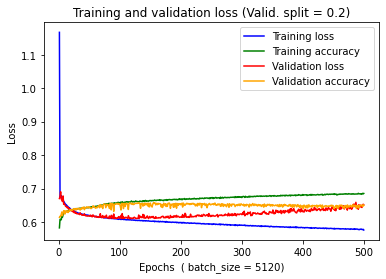

In [13]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'blue', label='Training loss')
plt.plot(epochslist, acc_values,'green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [14]:
y_test_pred = pd.DataFrame(model.predict( X_test  ) )
y_train_pred = pd.DataFrame(model.predict( X_train  ) )

In [15]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
fpr_train, tpr_train, thresholds_train = roc_curve( y_train, y_train_pred )

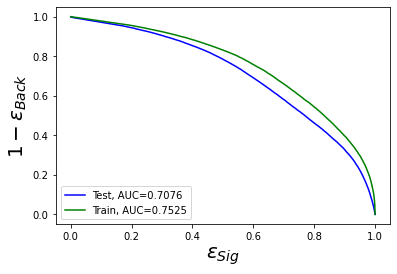

In [16]:
auc_val_test = auc(fpr_test, tpr_test)
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Test, AUC=' + str(round(auc_val_test,4)))
plt.plot( tpr_train, 1-fpr_train, 'g', label= 'Train, AUC=' + str(round(auc_val_train,4)))

plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'True positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-False positive rate' 
plt.legend(loc ='lower left')

Text(0, 0.5, 'Events')

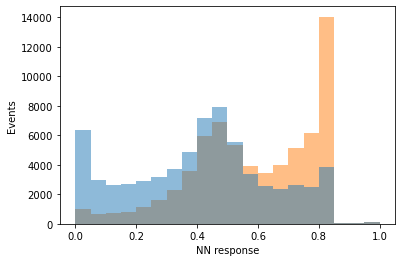

In [17]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_test_pred[y_test==0].values.flatten(),
    y_test_pred[y_test==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

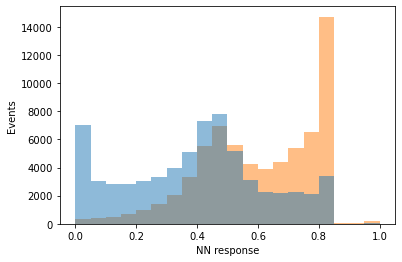

In [18]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_train_pred[y_train==0].values.flatten(),
    y_train_pred[y_train==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_train==0).sum()) +')' ,'Signal ('+ str((y_train==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

LBN Model

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from lbn import LBN, LBNLayer
from Tools.objects import Collections, choose
from Tools.basic_objects import getJets

In [2]:
def convertTo4Vec( df ):
       
    lead_lep = np.array(list(zip(
        df['lead_lep_energy'],
        df['lead_lep_px'],
        df['lead_lep_py'],
        df['lead_lep_pz'],
    )))
    
    sublead_lep = np.array(list(zip(
        df['sublead_lep_energy'],
        df['sublead_lep_px'],
        df['sublead_lep_py'],
        df['sublead_lep_pz'],
    )))

    jet1 = np.array(list(zip(
        df['j1_energy'],
        df['j1_px'],
        df['j1_py'],
        df['j1_pz'],
    )))
    
    jet2 = np.array(list(zip(
        df['j2_energy'],
        df['j2_px'],
        df['j2_py'],
        df['j2_pz'],
    )))
    
    jet3 = np.array(list(zip(
        df['j3_energy'],
        df['j3_px'],
        df['j3_py'],
        df['j3_pz'],
    )))
    
    jet4 = np.array(list(zip(
        df['j4_energy'],
        df['j4_px'],
        df['j4_py'],
        df['j4_pz'],
    )))
    
    jet5 = np.array(list(zip(
        df['j5_energy'],
        df['j5_px'],
        df['j5_py'],
        df['j5_pz'],
    )))

    particles = np.array(list(zip(lead_lep, sublead_lep, jet1, jet2, jet3, jet4, jet5)))
    return particles

In [3]:
def prepare_data(f_in, selection, robust=False, reuse=False, fout=None, label_ID='label'):

    if not reuse:
        
        df = pd.read_hdf(f_in) # load data processed with ML_processor.py
        df = df[selection]


        labels = df[label_ID].values
        process_labels = df['label'].values
        
        df = df[(process_labels<5)]
        labels = labels[process_labels<5] # filter out high weight DY events

        df = df[(labels<5)]
        labels = labels[labels<5] # filter out high weight DY events
        
        df_signal = df[(df[label_ID]==0)]
        df_bkg    = df[(df[label_ID]==1)]
        df_in = pd.concat([df_signal, df_bkg])
        labels = df_in[label_ID].values
        

        df_train, df_test, y_train, y_test = train_test_split(df_in, labels, train_size= int( 0.9*labels.shape[0] ), random_state=42 )

        df_train['test_label'] = np.zeros(len(df_train))
        df_test['test_label'] = np.ones(len(df_test))

        df = pd.concat([df_train, df_test])

        if fout:
            df.to_hdf(fout, key='df', format='table', mode='w')

    else:
        df = pd.read_hdf(f_in)

        df_train = df[df['test_label']==0]
        df_test = df[df['test_label']==1]

        y_train = df_train[label_ID].values
        y_test = df_test[label_ID].values

    for i in range(5):
        print ("Number of events in category %s:"%i, len(df[df[label_ID]==i]))

    return df_train, df_test, y_train, y_test#, df_mean, df_std



In [4]:
df = pd.read_hdf('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5')
preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))
df_train, df_test, y_train, y_test = prepare_data('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5', preselection, reuse=False, fout='data/multiclass_input_v4_split_%s.h5', label_ID='label')

                  
X_train = convertTo4Vec(df_train)
X_test  = convertTo4Vec(df_test)

<ipython-input-3-ff6b6e557f06>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['test_label'] = np.zeros(len(df_train))
<ipython-input-3-ff6b6e557f06>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['test_label'] = np.ones(len(df_test))


Number of events in category 0: 88155
Number of events in category 1: 41409
Number of events in category 2: 0
Number of events in category 3: 0
Number of events in category 4: 0


In [5]:
epochs = 50  # 50 -> 200
batch_size = 5120
validation_split = 0.2

In [20]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((7, 4), n_particles=7, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='gelu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='gelu' ) )
model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
model.add( tf.keras.layers.Dense(units=128, activation='gelu' ) )
model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
model.add( tf.keras.layers.Dense(units=256, activation='gelu') )
model.add( tf.keras.layers.Dense(units=128, activation='gelu') )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 






# compile the model
model.compile( loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(X_train)

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=validation_split, verbose=0)

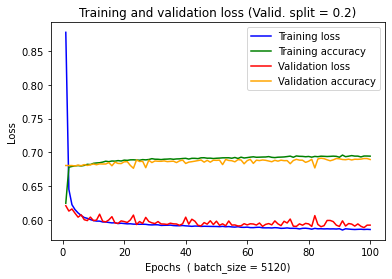

In [22]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, color='blue', label='Training loss')
plt.plot(epochslist, acc_values, color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [23]:
y_test_pred = pd.DataFrame(model.predict( X_test  ) )
y_train_pred = pd.DataFrame(model.predict( X_train  ) )

fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
fpr_train, tpr_train, thresholds_train = roc_curve( y_train, y_train_pred )

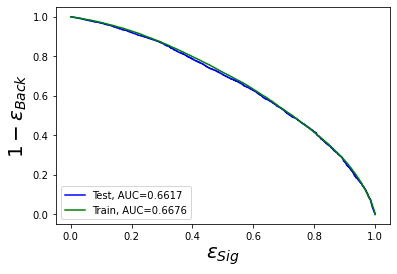

In [24]:
auc_val_test = auc(fpr_test, tpr_test)
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Test, AUC=' + str(round(auc_val_test,4)))
plt.plot( tpr_train, 1-fpr_train, 'g', label= 'Train, AUC=' + str(round(auc_val_train,4)))

plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'True positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-False positive rate' 
plt.legend(loc ='lower left')

Text(0, 0.5, 'Events')

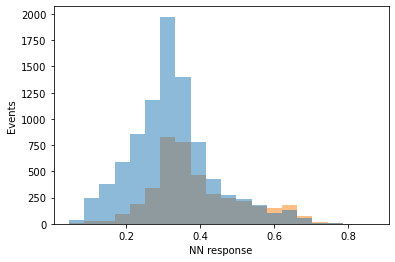

In [25]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_test_pred[y_test==0].values.flatten(),
    y_test_pred[y_test==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

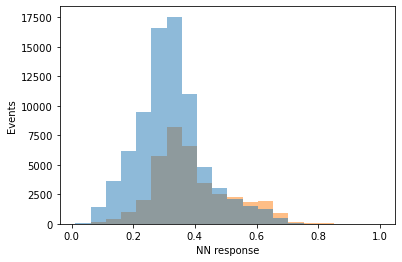

In [26]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_train_pred[y_train==0].values.flatten(),
    y_train_pred[y_train==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_train==0).sum()) +')' ,'Signal ('+ str((y_train==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')